In [1]:
from IPython.display import Image

# <a id="1.Summary"> 1.Summary</a>

Seq2Seq in machine translate

<br>

# <a id="2.Table of Contents">2.Tabole of Contents</a>
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Preprocess">Preprocess</a>
    <ul>
        <li><a href="#3.1 Hyperparameter">3.1 Hyperparameter</a></li>
        <li><a href="#3.2 Import Data">3.2 Import Data</a></li>
        <li><a href="#3.3 Preprocess Data">3.3 Preprocess Data</a></li> 
        <li><a href="#3.5 EDA">3.5 EDA</a></li>  
        <li><a href="#3.6 Tokenize">3.6 Tokenize</a></li>
        <li><a href="#3.7 category">3.7 Category</a></li>
    </ul>
    </li>
    <li><a href="#5.Models">Models</a>
    <ul>
        <li><a href="#6.1 Seq2Seq Attention">6.1 DNN</a></li>
        <li><a href="#6.2 Complile and Fit">6.2 Complile and Fit</a></li>
    </ul>
    </li>
    <li><a href="#6.Analysis and Plot">Analysis and Plot</a></li>
    <li><a href="#7.Main Function">Main Function</a></li>
    <li><a href="#9.Test Code">Test Code</a></li>
</ol>


<br>

# <a id="3.Preprocess">3.Preprocess</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

### <a id="3.1 HyperParameters">3.1 HyperParameters</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [2]:

class HyperParameter(object):
    def __init__(self):
        """

        """
        # we can change read file path
        self.PATH = "03_data/"

        # whole dataset is too large, we only use a small sample
        self.SAMPLE = 10000
        self.TEST_SAMPLE = 2000


        # max_words decided how many frequence words will present to you.
        # For instance, if we use max_unique words, 12175 for english part, this menas we will not abnondan any words in sentecne
        # if we set MAX_WORDS=1000, this menas, we only reserve most frequence Top 1000 words in each sentence. On this condition,
        # only some most common words will be resvers
        # if we set MAX_WORDS = 10, only stop words will be resever.
        # in the meantime, word_index and index_word will rematin same and full dictionray

        # self.MAX_WORDS_EN = 12175
        self.MAX_WORDS_EN = 5000
        # the max unique wrod is 16419, but we need to set this paramter in to max+1,
        # because keras.Tokenize() function only keep num_words-1 words, so if we want to keep all words
        # we either add 1 in tokenzie() function, or we set this parameters+1
        # Most important is in to_category() function, keras expect an integer vector from 0 to num_calss
        # but Tokenize() function provide word_index start from 1 to num_words-1,
        # so if we set parameters here as max+1, to_category can find 16419(max word)
        # 16420, memeory out....
        self.MAX_WORDS_ES = 5000
        # self.MAX_WORDS_EN = 1000
        # self.MAX_WORDS_ES = 16419
        # self.MAX_WORDS_ES = 10
        # self.MAX_WORDS_ES = 500

        self.MAX_SEQ_LEN_EN = 100
        self.MAX_SEQ_LEN_ES = 100


        self.EMBEDDING_DIM = 50


        self.BATCH_SIZE = 8
        self.EPOCHS = 1

        self.NAME_STR = 'Seq2Seq'
        """
        If we use max_len to cut sentence, it's ok for english part, but for spanish part
        we will cut the <end>
        
        """


### <a id="3.2 Import Data">3.2 Import Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split


from class_31_HyperParameter import HyperParameter

class ImportData(HyperParameter):
    """
    Include process moduel

    """
    def __init__(self):
        """

        """
        HyperParameter.__init__(self)

    def import_data(self):
        """

        :return:
        """
        # we use assign root path + file name to read this firl
        en_path = self.PATH + "europarl-v7.es-en.en"
        # this file didn't use potifix, so we need use open() function to read it into list
        # try to use 'utf-8' decode
        with open(en_path, 'r', encoding = 'utf-8') as f:
            # each sentence is seperate by line
            corpus_en_list = f.read().split('\n')

        # read spanish part
        es_path = self.PATH + "europarl-v7.es-en.es"
        with open(es_path, 'r', encoding = 'utf-8') as f:
            # each sentence is seperate by line
            corpus_es_list = f.read().split('\n')

        # build a dictionary first and then concatneate into a dataframe
        data = {'english': corpus_en_list[:-1],
                'spanish': corpus_es_list[:-1]}
        df = pd.DataFrame(data)

        # we have almost 2 million pairs, so I only use 10k as my running sample
        self.df_sample = df.sample(n = self.SAMPLE, random_state = 1024)

        return self.df_sample


    def split_data(self):
        """

        :return:
        """
        X_train, X_test = train_test_split(self.df_sample, test_size = 0.2, random_state = 1024)

        return X_train, X_test
    #


In [4]:
# pre_class = Preprocess()
# df_en = pre_class.import_data()

<br>

### <a id="3.3 Preprocess Data">3.3 Preprocess Data</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [5]:
import unicodedata
import re

from class_31_HyperParameter import HyperParameter

class PreProcess(HyperParameter):
    """

    """
    def __init__(self):
        """

        """
        HyperParameter.__init__(self)

    def unicode_to_ascii(self, s):
        """
        transform unicode to ascii. Because French have special letter
        that English don't have, so we need transform them into same format
        if we want to train or use them.
        We use unicodeatta.normlize to transoform single character by 'NFC',
        if this character is not Nonspcsing_Mark,
        which means most of time character is 'Lu' and 'Ll'
        https://towardsdatascience.com/difference-between-nfd-nfc-nfkd-and-nfkc-explained-with-python-code-e2631f96ae6c

        'Mn' = Nonspacing_Mark = a nonspacing combining mark (zero advance width)
        """
        #     return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
        return ''.join(c for c in unicodedata.normalize('NFC', s) if unicodedata.category(c) != 'Mn')

    def normalize_string(self, s):
        """
        normalize function complete
        """
        s = self.unicode_to_ascii(s)
        #  \1 is the replacement to use in case of a match, so a repeated word will be replaced by a single word.
        s = re.sub(r'([!.?])', r' \1', s)
        # replace any not letter and .!? with whitespace
        s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
        # replace several white space into one whitespace. because we replace a lot of non-charcters
        # into whitespace, so we may got multi-whitespace, we need substract to one
        s = re.sub(r'\s+', r' ', s)
        return s

    def transform(self, df):
        """
        clean up text, transfrom 'en' column to normalize and restore them as list
        :return:
        """
        # transform and clean ['english'] column
        corpus_en_list = [self.normalize_string(s) for s in df['english']]

        # add special token <start>/<end> to indicate the beginning and end of a sentence
        # <start> = <BOS>, <end> = <EOS>
        # so raw_in like timestep t, and raw_out like timestep t+1
        corpus_es_in = ['<start> ' + self.normalize_string(s) for s in df["spanish"]]
        corpus_es_out = [self.normalize_string(s) + ' <end>' for s in df["spanish"]]

        return corpus_en_list, corpus_es_in, corpus_es_out

<br>

### <a id="3.5 EDA">3.5 EDA</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [6]:
# make picture
import matplotlib.pyplot as plt
# draw picture
import seaborn as sns
import numpy as np

class EDA(object):

    def eda_length(self, raw_list):
        sentence_len = [len(x) for x in raw_list]
        sentence_len_arr = np.array(sentence_len)
        # change the type to numpy array and get 95%/90%/85%th percentile of the data value
        print(f"100%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 100)}")
        print(f"95%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 95)}")
        print(f"90%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 90)}")
        print(f"85%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 85)}")
        print(f"80%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 80)}")
        print(f"70%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 70)}")
        print(f"50%th percentile of sentence lenght is {np.percentile(sentence_len_arr, 50)}")
        # get sorted
        sentence_len.sort()
        plt.plot(np.arange(len(sentence_len)), sentence_len)
        plt.title("Sentence Length Distribution")
        plt.xlabel("Sentence Amount")
        plt.ylabel("Sentence Length")
        plt.show()
        print(
            f"For MAX_SEQ_LEN, 1000 words in one sentce will reasonable to preseve 90% sentence and delete outlier value")

        return None

In [7]:
# eda_class = EDA()
# eda_class.eda_length(corpus_es_in)

# eda_class = EDA()
# eda_class.eda_length(corpus_es_out)



### <a id="3.6 Tokenize">3.6 Tokenize</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from class_31_HyperParameter import HyperParameter

class Tokenize(HyperParameter):
    """

    """

    def __init__(self):
        """

        """
        HyperParameter.__init__(self)


    def tokenize(self, corpus_en_list, corpus_es_in, corpus_es_out, language ,token=None):
        """
        Argus:
        -----
        language:str
            we use this to control which paramters we use

        token:
            When we provide token we train_tokenize, we means use train_tokenzie to fit test dataset
        :return:
        """
        if language == 'en':
            MAX_WORDS = self.MAX_WORDS_EN
            corpus = corpus_en_list
            MAX_SEQ_LEN = self.MAX_SEQ_LEN_EN
        elif language == 'es_in':
            MAX_WORDS = self.MAX_WORDS_ES
            corpus = corpus_es_in
            MAX_SEQ_LEN = self.MAX_SEQ_LEN_ES
        elif language == 'es_out':
            MAX_WORDS = self.MAX_WORDS_ES
            corpus = corpus_es_out
            MAX_SEQ_LEN = self.MAX_SEQ_LEN_ES
        else:
            print("language input error")

        # this is test part
        if token!=None:
            # because we don't have <OOV> requirement
            # (each words need to be represent in translate task), so we don't assign <OOV>
            print(f"MAX_WORDS is {MAX_WORDS}")
            # This function only keep the most common num_words-1 words to be kept.
            # So, if we want to keep all words, we need to plus 1 in here
            # tokenizer = Tokenizer(filters='', num_words = MAX_WORDS, oov_token="<OOV>")
            # use training tokenizer
            tokenizer = token
            tokenizer.fit_on_texts(corpus)
            seq = tokenizer.texts_to_sequences(corpus)
            print(f"MAX_SEQ_LEN is {MAX_SEQ_LEN}")
            padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post')
            word_index, index_word = tokenizer.word_index, tokenizer.index_word

        # this is train part
        else:
            # because we don't have <OOV> requirement
            # (each words need to be represent in translate task), so we don't assign <OOV>
            print(f"MAX_WORDS is {MAX_WORDS}")
            # This function only keep the most common num_words-1 words to be kept.
            # So, if we want to keep all words, we need to plus 1 in here
            tokenizer = Tokenizer(filters='', num_words = MAX_WORDS, oov_token="<OOV>")
            tokenizer.fit_on_texts(corpus)
            seq = tokenizer.texts_to_sequences(corpus)
            print(f"MAX_SEQ_LEN is {MAX_SEQ_LEN}")
            padded = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post')
            word_index, index_word = tokenizer.word_index, tokenizer.index_word


        return word_index, index_word, seq, padded, tokenizer



    def sequence_to_text(self, padded, index_word):
        """
        Use this function to convert padded sequnce back to text according to word_index
        """
        # create a empty list
        word_list = []
        for idx, i in enumerate(padded):
            # for every word in self.question_padded[0]=sentence, put it into a list
            words = np.array([index_word.get(word) for word in i])
            # insert into list
            word_list.append(words)
        # create a dictionary to build DataFrame
        dic = {"sequence_to_text": word_list}
        word_df = pd.DataFrame(dic)
        return word_df




In [9]:
# 

### <a id="3.7 category">3.7 category</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [10]:
from tensorflow.keras.utils import to_categorical


from class_31_HyperParameter import HyperParameter


class ToCategory(HyperParameter):
    """

    """
    def __init__(self):
        """

        """
        # HyperParameter.__init__(sefl)
        super(ToCategory, self).__init__()

    def to_category(self, padded):
        """
        Argus:
        -----

        :param padded:
        :return:
        """
        padded_cat = to_categorical(padded, num_classes = self.MAX_WORDS_ES)
        print(padded_cat.shape)

        return padded_cat




In [11]:
# cate_class = ToCategory()
# es_out_padded_cat = cate_class.to_category(es_out_padded)

# <a id="5.Models">5.Models</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

### <a id="5.1 Seq2Seq Attention">5.1 Seq2Seq Attention</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [12]:
from tensorflow.keras.layers import Embedding, Lambda, Dot, Activation, Concatenate, Dropout, Input, LSTM, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

# draw the structure of this model
from tensorflow.keras.utils import model_to_dot, plot_model
# dispaly structure and saved picture
from IPython.display import Image, display


from class_31_HyperParameter import HyperParameter

class Seq2Seq(HyperParameter):
    """

    """

    def __init__(self):
        """

        """
        HyperParameter.__init__(self)

    def seq_atten(self):
        """

        :return:
        """
        self.encoder_input_1 = Input(shape=(self.MAX_SEQ_LEN_EN,), name='encoder_input_layer')
        # if we didn't assign input_shape, Embedding layer will use input_length as input_shape
        # which means it will fit Input layers and input_shape will be padded with english part sentence length
        # enghlish sentence maximize we set as 100, but actually it should longer than that, as least 300
        # Typically, input_dim show be max
        encoder_embed_2 = Embedding(input_dim=self.MAX_WORDS_EN,
                                    output_dim=self.EMBEDDING_DIM,
                                    input_length=self.MAX_SEQ_LEN_EN,
                                    name='encoder_embedding_layer')(self.encoder_input_1)
        # this layer can be imporoved and replaced
        # LSTM is read each word, so input is individual word vector
        encoder_lstm_3 = LSTM(units=self.EMBEDDING_DIM,
                              return_sequences=True,
                              return_state=True,
                              dropout=0.2,
                              name='encoder_lstm_3')
        encoder_outputs, state_h, state_c = encoder_lstm_3(encoder_embed_2)
        self.encoder_states = [state_h, state_c]

        # Set up the decoder, using `encoder_states` as initial state.
        # the shape of decoder_inputs is set to None so it can translate
        # with a single word input, not necessary a sentence input
        self.decoder_inputs_4 = Input(shape=(None,), name='decoder_input_4')
        # deocder didn't have input_length, it seems no sentence length limitation
        self.decoder_embedding_5 = Embedding(input_dim=self.MAX_WORDS_ES,
                                        output_dim=self.EMBEDDING_DIM,
                                        name='decoder_embedding_5')(self.decoder_inputs_4)
        self.decoder_lstm_6 = LSTM(units=self.EMBEDDING_DIM,
                              return_sequences=True,
                              return_state=True,
                              dropout=0.2,
                              name='decoder_lstm_6')
        decoder_output, _, _ = self.decoder_lstm_6(self.decoder_embedding_5, initial_state=self.encoder_states)

        # Transform encoder outputs to a space which can be aligned with decoder output
        encoder_outputs_transformed = Dense(units=self.EMBEDDING_DIM,
                                            activation=None,
                                            use_bias=False)(encoder_outputs)

        # calculate alignment between decoder and encoder
        attention = Dot(axes=[2, 2])([decoder_output, encoder_outputs_transformed])
        attention = Activation('tanh')(attention)

        # Normalize alignment score
        attention = Activation('softmax')(attention)

        # weighted sum
        context = Dot(axes=[2, 1])([attention, encoder_outputs])

        # Concatenate context with decoder output
        decoder_combined_context = Concatenate(axis=-1)([context, decoder_output])

        self.decoder_dense = Dense(units=self.MAX_WORDS_ES, activation='softmax')(decoder_combined_context)
        # decoder_dense = Dense(units = self.MAX_WORDS_ES, activation = 'softmax')
        # decoder_final_output = decoder_dense(decoder_combined_context)

        model = Model(inputs=[self.encoder_input_1, self.decoder_inputs_4],
                      outputs=self.decoder_dense)

        model.summary()

        dot_img_file = '04_images/10_Seq2Seq_attention.png'
        plot_model(model, to_file=dot_img_file, show_shapes=True)
        display(Image(filename='04_images/10_Seq2Seq_attention.png'))

        return model

    def predict(self):
        """

        :return:
        """
        # encoder_input_1 = Input(shape=(self.MAX_SEQ_LEN_EN,), name='encoder_input_layer')
        # # if we didn't assign input_shape, Embedding layer will use input_length as input_shape
        # # which means it will fit Input layers and input_shape will be padded with english part sentence length
        # # enghlish sentence maximize we set as 100, but actually it should longer than that, as least 300
        # # Typically, input_dim show be max
        # encoder_embed_2 = Embedding(input_dim=self.MAX_WORDS_EN,
        #                             output_dim=self.EMBEDDING_DIM,
        #                             input_length=self.MAX_SEQ_LEN_EN,
        #                             name='encoder_embedding_layer')(encoder_input_1)
        # # this layer can be imporoved and replaced
        # # LSTM is read each word, so input is individual word vector
        # encoder_lstm_3 = LSTM(units=self.EMBEDDING_DIM,
        #                       return_sequences=True,
        #                       return_state=True,
        #                       dropout=0.2,
        #                       name='encoder_lstm_3')
        # encoder_outputs, state_h, state_c = encoder_lstm_3(encoder_embed_2)
        # encoder_states = [state_h, state_c]

        # encoder and decoder models in inference
        # encoder_inputs comes from english input layer
        # encoder_states also come from output of encoder_LSTM
        encoder_model = Model(inputs = self.encoder_input_1,
                              outputs = self.encoder_states)

        decoder_state_input_h = Input(shape = (self.EMBEDDING_DIM,), name = "decoder_h")
        decoder_state_input_c = Input(shape=(self.EMBEDDING_DIM,), name="decoder_c")
        decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

        # decoder_embedding comes from france decoder part, which have
        decoder_embed = self.decoder_embedding_5(self.decoder_inputs_4)
        decoder_outputs, state_h, state_c = self.decoder_lstm_6(decoder_embed,
                                                                initial_state = decoder_state_inputs)

        deocder_states = [state_h, state_c]
        decoder_outputs = self.decoder_dense(deocder_states)

        decoder_model = Model(inputs = [self.decoder_inputs_4] + decoder_state_inputs,
                              outpus = [decoder_outputs]  + deocder_states)

        decoder_model.summary()

        dot_img_file = '04_images/11_encoder_model.png'
        plot_model(decoder_model, to_file=dot_img_file, show_shapes=True)
        display(Image(filename='04_images/11_encoder_model.png'))

        dot_img_file = '04_images/12_decoder_model.png'
        plot_model(decoder_model, to_file=dot_img_file, show_shapes=True)
        display(Image(filename='04_images/12_decoder_model.png'))

        return encoder_model, decoder_model

    def decode_sequence(input_seq):  # input_seq is a English sentence

        # Encode the input as state vectors.
        states_value = encoder_model.predict(input_seq)

        # Generate empty target sequence of length 1. (i.e. we translate word by word)
        target_seq = np.zeros((1, 1))

        # Populate the start symbol of target sequence with the start character.
        target_seq[0, 0] = fr_tokenizer.word_index["<start>"]

        # Generate word by word using the encode state and the last
        # generated word

        decoded_sentence = []

        while True:

            output_tokens, h, c = decoder_model.predict(
                [target_seq] + states_value)

            # Get the most likely word
            sampled_token_index = np.argmax(output_tokens[0, 0, :])

            # Look up the word by id
            sampled_word = reverse_fr_word_index[sampled_token_index]

            decoded_sentence.append(sampled_word)

            # Exit condition: either hit max length
            # or find stop character.
            if (sampled_word == '<end>' or len(decoded_sentence) == max_fr_len):
                break

            # Update the target sequence with newly generated word.
            target_seq[0, 0] = sampled_token_index

            # Update states
            states_value = [h, c]

        return ' '.join(decoded_sentence)

In [13]:
# seq_class = Seq2Seq()
# model = seq_class.seq_atten()

### <a id="5.2 Complie and Fit">5.2 Complie and Fit</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [14]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from class_31_HyperParameter import HyperParameter

class CompileFit(HyperParameter):
    """

    """
    def __init__(self):
        """

        """
        super(CompileFit, self).__init__()

    def complie_fit(self, model, en_padded, es_in_padded, es_out_padded_cat):
        """

        :return:
        """
        model.compile(optimizer = 'rmsprop',
                      loss = 'categorical_crossentropy',
                      metrics=['categorical_accuracy']
                      # loss = losses.SparseCategoricalCrossentropy()
                      # metrics = metrics.sparse_categorical_accuracy()
                      )
        history = model.fit(x = [en_padded, es_in_padded],
                            y = es_out_padded_cat,
                            batch_size = self.BATCH_SIZE,
                            epochs = self.EPOCHS,
                            verbose = 1,
                            validation_split = 0.2)

        history_dict = [x for x in history.history]

        return history, history_dict

# <a id="6.Analysis">6. Analysis</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [15]:
import pandas as pd
import numpy as np
# plot image
import matplotlib.pyplot as plt
from class_31_HyperParameter import HyperParameter

class Analysis(HyperParameter):
    """

    """

    def plot_history(self, history):
        """
        This function is used for plot classification self.history result
        :param self.history:
        :return:
        """
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        # ****loss plost *******************
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.plot(hist['epoch'], hist['loss'],
                 label='Train loss')
        plt.plot(hist['epoch'], hist['val_loss'],
                 label='Val loss')
        plt.ylim([0, 3])
        plt.legend()
        plt.savefig(f'04_images/{self.NAME_STR}_loss.png', dpi=150, format='png')
        # plt.savefig(f'/googledrive/MyDrive/04_images/{self.NAME_STR}_loss.png', dpi=150, format='png')

        # ****************accuracy plot******************
        plt.figure()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.plot(hist['epoch'], hist['accuracy'],
                 label='Train Accuracy')
        plt.plot(hist['epoch'], hist['val_accuracy'],
                 label='Val Accuracy')
        plt.ylim([0, 1])
        plt.legend()
        plt.savefig(f'04_images/{self.NAME_STR}_acc.png', dpi=150, format='png')
        # plt.savefig(f'/googledrive/MyDrive/04_images/{self.NAME_STR}_acc.png', dpi=150, format='png')
        plt.show()
        return hist




<br>

<br>

<br>

# <a id="7.Main Function">7.Main Function</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

MAX_WORDS is 5000
MAX_SEQ_LEN is 100
MAX_WORDS is 5000
MAX_SEQ_LEN is 100
MAX_WORDS is 5000
MAX_SEQ_LEN is 100
MAX_WORDS is 5000
MAX_SEQ_LEN is 100
MAX_WORDS is 5000
MAX_SEQ_LEN is 100
MAX_WORDS is 5000
MAX_SEQ_LEN is 100
(8000, 100, 5000)
(2000, 100, 5000)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_layer (InputLayer [(None, 100)]        0                                            
__________________________________________________________________________________________________
decoder_input_4 (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding_layer (Embedd (None, 100, 50)      250000      encoder_input_layer[0][0]        
________________________________

Train on 6400 samples, validate on 1600 samples
Epoch 1/3
6400/6400 [==============================] - 86s 13ms/sample - loss: 1.8797 - categorical_accuracy: 0.7245 - val_loss: 1.5982 - val_categorical_accuracy: 0.7474
Epoch 2/3
6400/6400 [==============================] - 80s 12ms/sample - loss: 1.5752 - categorical_accuracy: 0.7499 - val_loss: 1.5184 - val_categorical_accuracy: 0.7577
Epoch 3/3
6400/6400 [==============================] - 80s 12ms/sample - loss: 1.5078 - categorical_accuracy: 0.7593 - val_loss: 1.4694 - val_categorical_accuracy: 0.7659


KeyError: 'accuracy'

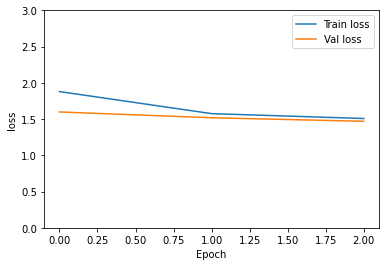

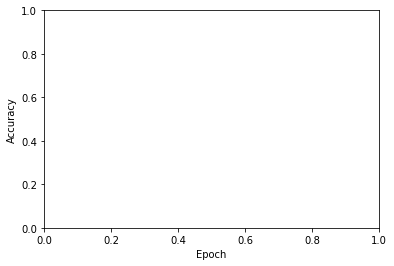

In [19]:

# from class_31_HyperParameter import HyperParameter
# from class_32_ImportData import ImportData
# from class_33_PreProcess import PreProcess
# from class_35_EDA import EDA
# from class_36_Tokenize import Tokenize
# from class_37_categoory import ToCategory
# from class_51_models import Seq2Seq
# from class_52_compile_fit import CompileFit
# from class_61_analysis import Analysis


def main():
    """
    Pipeline:
    1.Import Data
    :return:
    """
    #************1.Import Data****************
    import_class = ImportData()
    df = import_class.import_data()
    df_train, df_test = import_class.split_data()


    #****************2.Preprocess*************
    pre_class = PreProcess()
    corpus_train_en_list, corpus_train_es_in, corpus_train_es_out = pre_class.transform(df_train)
    corpus_test_en_list, corpus_test_es_in, corpus_test_es_out = pre_class.transform(df_test)

    #****************EDA******************
    # eda_class = EDA()
    # eda_class.eda_length(corpus_en_list)

    #*************tokenize*****************
    token_class = Tokenize()
    _, _, _, train_en_padded, train_en_token = token_class.tokenize(corpus_train_en_list,
                                                                    corpus_train_es_in,
                                                                    corpus_train_es_out,
                                                                    language='en')

    _, _, _, train_es_in_padded, train_es_in_token = token_class.tokenize(corpus_train_en_list,
                                                                          corpus_train_es_in,
                                                                          corpus_train_es_out,
                                                                          language='es_in')

    _, _, _, train_es_out_padded, train_es_out_token = token_class.tokenize(corpus_train_en_list,
                                                                     corpus_train_es_in,
                                                                     corpus_train_es_out,
                                                                     language='es_out')

    _, _, _, test_en_padded, test_en_token = token_class.tokenize(corpus_test_en_list,
                                                                  corpus_test_es_in,
                                                                  corpus_test_es_out,
                                                                  language='en',
                                                                  token = train_en_token)

    _, _, _, test_es_in_padded, test_es_in_token = token_class.tokenize(corpus_test_en_list,
                                                                  corpus_test_es_in,
                                                                  corpus_test_es_out,
                                                                  language='es_in',
                                                                  token = train_es_in_token)

    _, _, _, test_es_out_padded, test_es_out_token = token_class.tokenize(corpus_test_en_list,
                                                                  corpus_test_es_in,
                                                                  corpus_test_es_out,
                                                                  language='es_out',
                                                                  token = train_es_out_token)

    #******************category************************
    cat_class = ToCategory()
    train_es_out_padded_cat = cat_class.to_category(train_es_out_padded)
    test_es_out_padded_cat = cat_class.to_category(test_es_out_padded)
    #
    model_class = Seq2Seq()
    seq_model = model_class.seq_atten()

    compile_class = CompileFit()
    history, hist_dict = compile_class.complie_fit(
        seq_model, train_en_padded, train_es_in_padded, train_es_out_padded_cat
    )

    #***************Analysis***************
    plt_class = Analysis()
    plt_class.plot_history(history)



    return (df, df_train, df_test,
            corpus_train_en_list, corpus_train_es_in, corpus_train_es_out,
           train_en_padded, train_es_in_padded, train_es_out_padded,
            history)


if __name__=="__main__":
    (df, df_train, df_test,
     corpus_train_en_list, corpus_train_es_in, corpus_train_es_out,
     train_en_padded, train_es_in_padded, train_es_out_padded,
     history) = main()
    print("OVER")

<br>

# <a id="9.Test Code">9.Test Code</a>
<a href="#2.Table of Contents">Click this Link back to Top</a>

In [ ]:
# def test(token=None):
#     if token != None:
#         print("123")
#     else:
#         print("345")
        
# test()

In [ ]:
# token_class = Tokenize()
# word_index, index_word, seq, padded = token_class.tokenize(corpus_en_list, corpus_es_in, corpus_es_out, language = 'es_out')

# token_class = Tokenize()
# en_word_index, en_index_word, es_out_seq, es_out_padded = token_class.tokenize(corpus_en_list,
#                                                                  corpus_es_in,
#                                                                  corpus_es_out,
#                                                                  language='es_out')

# es_out_padded.max()

# en_index_word[16419]

# word_df = token_class.sequence_to_text(padded, index_word)
# word_df.iloc[0,0]

# index_word.get(3430)

# padded

# word_df

# word_index

# index_word

# len(word_index)

# type(padded)

# padded.shape

# np.amax(padded)

# padded.max()

# corpus_es_out[0]

# padded[0,:]

# es_out_padded.max()

In [ ]:
# es_out_padded

In [ ]:
# import tensorflow as tf
# # test for CuDNN
# batch_size = 64
# # Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# # Each input sequence will be of size (28, 28) (height is treated like time).
# input_dim = 28

# units = 64
# output_size = 10  # labels are from 0 to 9

# # Build the RNN model
# def build_model(allow_cudnn_kernel=True):
#     # CuDNN is only available at the layer level, and not at the cell level.
#     # This means `LSTM(units)` will use the CuDNN kernel,
#     # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
#     if allow_cudnn_kernel:
#         # The LSTM layer with default options uses CuDNN.
#         lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
#     else:
#         # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
# #         lstm_layer = tf.keras.layers.RNN(
# #             tf.keras.layers.LSTMCell(units), input_shape=(None, input_dim)
# #         )
#         lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim), recurrent_dropout = 0)
#     model = tf.keras.models.Sequential(
#         [
#             lstm_layer,
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(output_size),
#         ]
#     )
#     return model

In [ ]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
# sample, sample_label = x_train[0], y_train[0]

In [ ]:
# model = build_model(allow_cudnn_kernel=True)

# model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer="sgd",
#     metrics=["accuracy"],
# )


# model.fit(
#     x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
# )

In [ ]:
# noncudnn_model = build_model(allow_cudnn_kernel=False)
# noncudnn_model.set_weights(model.get_weights())
# noncudnn_model.compile(
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer="sgd",
#     metrics=["accuracy"],
# )
# noncudnn_model.fit(
#     x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
# )

In [ ]:
# def token(corpus):
#     print(str(corpus))

In [ ]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# check_tokenizer = Tokenizer(filters='')
# check_tokenizer.fit_on_texts(corpus_en_list)
# word_index, word_count = check_tokenizer.word_index, check_tokenizer.word_counts
# print(f"we got unique {len(word_index)} words")
# MAX_WORD = 0
# for i in word_count.values():
#     if i > 5:
#         MAX_WORD += 1
# print(f"we have {MAX_WORD} words appear more than 5 times")



# check_tokenizer = Tokenizer(filters='')
# check_tokenizer.fit_on_texts(corpus_es_in)
# word_index, word_count = check_tokenizer.word_index, check_tokenizer.word_counts
# print(f"we got unique {len(word_index)} words")
# MAX_WORD = 0
# for i in word_count.values():
#     if i > 5:
#         MAX_WORD += 1
# print(f"we have {MAX_WORD} words appear more than 5 times")





# import pandas as pd
# # df_1 = pd.read_csv("")
# # f = open("03_data/europarl-v7.es-en.en", "r")
# # print(f.read())
# df_1 = pd.read_json("03_data/europarl-v7.es-en.en", orient = 'split')

# df_1.shape

# df_1.head(6)

# f = open("03_data/europarl-v7.es-en.en", "r",  encoding='utf-8')
# print(f.read())

# with open('03_data/europarl-v7.es-en.en', 'r', encoding = 'utf-8') as f:
#     lines_1 = f.read().split('\n')

# # with open('03_data/europarl-v7.es-en.en', 'r') as f:
# #     lines_1 = f.read().split('\n')

# with open('03_data/europarl-v7.es-en.es', 'r', encoding = 'utf-8') as f:
#     lines_1 = f.read().split('\n')

# type(lines_1)

# len(lines_1)

# list_2 = lines_1[:-1]

# len(list_2)

# list_2[-1]